# Econometric models
This is a collection of classic econometric models that were used for the kaggle competition.
For more info, read README and our blog post.

In [1]:
%matplotlib inline
import os, os.path
import itertools
import pickle
import time
import numpy as np
import pandas as pd
from pyramid.arima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy.stats import describe
import warnings

D:\python\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


In [2]:
pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

# disable warnings in Anaconda
warnings.simplefilter('ignore')

# plots inisde jupyter notebook
%matplotlib inline

sns.set(style='darkgrid', palette='muted')
color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

## Seasonality

Choose seasonality model from above:

In [6]:
seasonality_model = additive
#seasonality_model = multiplicative

In [7]:
categorize_by_week_of_year = lambda df: df.index.dayofyear // 7
categorize_by_day_of_week = lambda df: df.index.dayofweek

In [9]:
def compute_seasonality(series, categorization):
    """
    Computes seasonal component parameters based on provided series.
    
    :type series: pd.Series
    :param categorization: Function used to split values into various periods of the season.
    :type categorization: pd.DataFrame -> some categorical type, eg. int
    """
    df = pd.DataFrame()
    df["values"] = series
    df.index = series.index
    df["cat"] = categorization(df)
    return df.groupby(by="cat")["values"].mean()

In [10]:
def alter_series_by_season(series, categorization, seasonality, op):
    df = pd.DataFrame()
    df["values"] = series
    df["values"] = series
    df["cat"] = categorization(df)
    return op(df["values"], df["cat"].map(seasonality))

In [11]:
def add_seasonal_component(series, categorization, seasonality):
    """
    Add previously computed seasonal component back into a deseasonalized series.
    
    :type series: pd.Series
    :param categorization: Function used to split values into various periods of the season.
    :type categorization: pd.DataFrame -> some categorical type, eg. int
    :param seasonality: value returned from compute_seasonality
    :returns: Series with added seasonal component.
    :rtype: pd.Series
    """
    return alter_series_by_season(series, categorization, seasonality, seasonality_model["op"])

In [13]:
def remove_seasonal_component(series, categorization, seasonality):
    """
    Try removing a previously computed seasonal component.
    
    :type series: pd.Series
    :param categorization: Function used to split values into various periods of the season.
    :type categorization: pd.DataFrame -> some categorical type, eg. int
    :param seasonality: value returned from compute_seasonality
    :returns: Deseasonalized series.
    :rtype: pd.Series
    """
    return alter_series_by_season(series, categorization, seasonality, seasonality_model["inv"])

## Holt-Winters and SARIMA Models Utils

In [22]:
def train_and_forecast(data, categorization, trainer, forecaster, deseasonize, steps_to_forecast=90):
    """
    Split input data, deseasonalizes train data,
    train using trainer (data -> model),
    forecast using forecaster
    
    predicts values and applies seasonalization and returns predicted vs actual values
    
    :param data: dataset with the training data
    :param categorization: Function used to split values into various periods of the season.
    :type categorization: pd.DataFrame -> some categorical type, eg. int
    :param trainer: Function used to train the model
    :type trainer: pd.DataFrame -> model
    :param forecaster: (model, steps) -> prediction
    :param steps_to_forecast:  number of steps to forecast
    :returns:  a dataframe with:
                                date
                                sales - true values
                                forecast - forecasted values
    """
    
    #prepare trainig and validation datasets
    df_train = data.iloc[:-365].copy()
    df_validation = data.iloc[-365:].copy()
    df_validation.index = pd.DatetimeIndex(df_validation["date"])
    df_train.index = pd.DatetimeIndex(df_train["date"])
    
    if deseasonize:
        seas = compute_seasonality(df_train["sales"], categorization)
        series = remove_seasonal_component(df_train["sales"], categorization, seas)
        df_train["sales"] = series
    
    df_train = df_train.reset_index(drop=True)

    # train
    model = trainer(df_train)
    
    # forecast
    forecast = forecaster(model, steps_to_forecast)
    
    # Create the pandas series from the forecast
    forecast = pd.Series(forecast)
    forecast.name = "sales"
    forecast.index = pd.DatetimeIndex(start='2017-01-01', 
                                      freq="D",
                                      periods = forecast.size)
    
    if deseasonize:
        forecast = add_seasonal_component(forecast, categorization, seas)
    
    final_forecast = pd.DataFrame()
    final_forecast['real_values'] = df_validation["sales"][:steps_to_forecast]
    final_forecast['forecast'] = forecast
    
    return final_forecast

In [23]:
def extract_single_df(data, store, item):
    """
    Extract single store/item time series from provided 
    dataset
    
    :param data: Pandas dataframe with multiple timeseries
    :param store: number of the store
    :param item: number of the item
    :returns: Pandas dataframe with single store/item time series
    """
    
    df_single = data.loc[(data.store == store) & (data.item == item),["date", "sales"]].copy()
    df_single.reset_index(drop=True, inplace=True)
    df_single.date = pd.to_datetime(df_single.date)
    return df_single

In [24]:
def compute_all_models(data, ids, categorization, trainer, forecaster, deseasonize, steps_to_forecast=90):
    """
    Train the models and use them to make forecast for all of the individual
    time series separately
    
    :params data: dataframe with multiple time series
    :params ids: list of tuples with stores and items
    :param categorization: Function used to split values into various periods of the season.
    :type categorization: pd.DataFrame -> some categorical type, eg. int
    :param trainer: Function used to train the model
    :type trainer: pd.DataFrame -> model
    :param forecaster: (model, steps) -> prediction
    :param steps_to_forecast: number of steps to forecast
    """
    
    all_models_forecast = {}
    all_models_smape = np.array([])
    number_of_time_series = 0
    for store, item in ids:
        single_time_series = extract_single_df(data, store, item)
        predictions = train_and_forecast(single_time_series, categorization,
                                         trainer, forecaster, deseasonize, steps_to_forecast)
        score = smape(predictions['real_values'], predictions['forecast'])
        results = {
            "item": item,
            "store": store,
            "predictions": predictions,
            "smape": score
        }
        print(score)
        all_models_smape = np.append(all_models_smape, score)
        all_models_forecast[str(store) + str(item)] = results
        number_of_time_series += 1
    forecast_smape = np.sum(all_models_smape) / number_of_time_series
        
    return results, forecast_smape

In [25]:
def smape(y, y_pred):
    """
    compute the SMAPE metrics
    
    :param y: array with true values
    :param y: array with forcasted values
    :returns: average smape metrics for the given period
    """
    
    div = (abs(y_pred) + abs(y)) / 2
    errors = abs(y_pred - y) / div
        
    smape = np.sum(errors) / len(y)
    return smape

In [26]:
def compute_avg_smape (df_y, df_y_pred):
    """
    Compute average SMAPE of multiple forecast
    
    :param df_y: data series with real values
    :param df_y_pred: dataframe with multiple forecasts
    :returns: average SMAPE of all forecasts
    """
    
    avg_smape = 0
    for i in range(df_y_pred.shape[1]):
        err = smape(y=df_y.iloc[:,i],
                              y_pred=df_y_pred.iloc[:,i])
        avg_smape += err

    avg_smape /= df_y_pred.shape[1]
    return avg_smape


### Data import & preparation 
In order for this to work, download all datasets from kaggle competition:  
https://www.kaggle.com/c/demand-forecasting-kernels-only  
and place them in `../data/` folder.  
We could not append datasets to our repo because of copyrights.

In [34]:
#Import data
dir_name = "../train.csv/" #insert your own path here
file_name = "train.csv"

filepath_train = os.path.abspath(os.path.join(os.getcwd(), dir_name, file_name ))

store_item_data = pd.read_csv(filepath_train)
store_item_data.index = pd.DatetimeIndex(store_item_data['date'])


In [35]:
print(store_item_data.index )

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=913000, freq=None)


In [36]:
number_of_stores = 10
number_of_items = 50

In [37]:
ids = list(itertools.product(range(1,number_of_stores+1), range(1,number_of_items+1)))

In [38]:
print(len(ids))
print(ids[:20])

500
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20)]


## Holt-Winters Method

In [41]:
# create a trainer which can be use to train all of the models
hw_trainer = lambda df: smt.ExponentialSmoothing(endog=df.loc[-365:,'sales'], damped=False,
                         trend='add',seasonal='add', seasonal_periods=7).fit()

In [40]:
# create a forecaster function to get the forcasts from all of the models
hw_forecaster = lambda model, steps: model.predict(steps)

In [33]:
hw_results, hw_smape = compute_all_models(store_item_data, ids, categorize_by_week_of_year,
                                         hw_trainer, hw_forecaster, False)
print("Holt Winters method SMAPE on the validation set: ", hw_smape)

0.28598555259953834
0.20827398188240298
0.21250942050208207
0.2793967442232333
0.26123599890573146
0.21826951371697095
0.21743769919366657


KeyboardInterrupt: 

## SARIMA

In [ ]:
# create a trainer which can be use to grid search and train all of the models
arima_trainer = lambda df: auto_arima(df.loc[-365:,'sales'], m=7, n_jobs=1, max_p=7, max_q=7, max_P=7,
                          max_Q=7, max_order=12, trend='c', max_iter=100,
                          trace=False, error_action='ignore', suppress_warnings=True,
                          stepwise=True, random=False, n_fits=40, random_state=44443)


In [ ]:
# create a forecaster function to get the forcasts from all of the models
arima_forecaster = lambda model, steps: model.predict(steps)

In [ ]:
sarima_results, sarima_smape = compute_all_models(store_item_data, ids, categorize_by_week_of_year,
                                         arima_trainer, arima_forecaster, True)
print("SARIMA model SMAPE on the validation set: ", sarima_smape)

## VAR

In [34]:
def var_train_and_forecast(data_train, data_validation, categorization, max_lags=16,ic='aic',
                            plots=False):
    """
    Apply deseasonalization and differencing to the time series and
    create VAR model with optimal number of lags, make forecast and compute smape
    
    :param data_train: training multivariete time series
    :param data_validation: validation  multivariete time series
    :param max_lags: maximum number of lags in VAR model
    :type max_lags: int
    :param ic: information criterion used to choose best VAR model
    :param plots: if True  forecast vs real_values plot will be printed
    
    returns: smape metric
    """
    
    #DESEASONALIZATION
    data_train_deseasonalized = pd.DataFrame()
    seasonalized_all = pd.DataFrame()

    for col in  data_train.columns.values:
        seasonalized_all[col] = compute_seasonality(data_train[col], categorization)
        series = remove_seasonal_component(data_train[col], categorization, seasonalized_all[col])
        data_train_deseasonalized[col] = series
    data_train_deseasonalized.index = pd.DatetimeIndex(start="01-01-2013",
                                                       periods=1461, freq='D')
    
    #TIME SERIES DIFFERENCING
    data_train_deseasonalized_differenced = data_train_deseasonalized.diff().iloc[1:]
    data_train_deseasonalized_differenced = data_train_deseasonalized_differenced.asfreq('D')
    
    #MODELING
    var_model = smt.VAR(data_train_deseasonalized_differenced,
                        dates=data_train_deseasonalized_differenced.index)
    
    var_model_results = var_model.fit(maxlags=max_lags, ic=ic, verbose=True)
    lags = var_model_results.k_ar
    
    #FORECASTING
    forecast = pd.DataFrame(var_model_results.forecast(
                            data_train_deseasonalized_differenced.values[-lags:], 90))
    forecast.columns +=1
    
    #FORCAST REVERSE DIFFERENCING
    var_forecast_diff = data_train_deseasonalized.tail(1)

    var_forecast_diff = var_forecast_diff.append(forecast)
    var_forecast = var_forecast_diff.cumsum().iloc[1:]
    var_forecast.index = pd.DatetimeIndex(start='01-01-2017', periods=90, freq='D')
    

    
    # FORCAST - APPLY SEASONALITY
    corrected_forecast = pd.DataFrame()
    for col in var_forecast.columns.values:
        tmp_forecast = pd.DataFrame()
        tmp_forecast = add_seasonal_component(var_forecast[col].copy(),
                                        categorize_by_week_of_year,
                                        seasonalized_all[col])
        corrected_forecast[col] = tmp_forecast
    corrected_forecast.index = pd.DatetimeIndex(start='01-01-2017', periods=90,freq='D')
    
    # forecast vs real_values plot
    if plots:
        plt.figure()
        corrected_forecast.iloc[:,0].plot(figsize=(12,16), color='b')
        data_validation.iloc[:90,0].plot(color='r')
        plt.show()
    smape = compute_avg_smape(df_y=data_validation.iloc[:90], df_y_pred=corrected_forecast)
    print(smape)
    return smape


In [35]:
def evaluate_multiple_var (data, num_time_series):
    """
    Compute and evaluate VAR model for every batch of multivariete time series
    :param data: multiindexed columns dataframe with multivariete time series
    :param number_of_series: number of mutivariete time series
    :returns: average SMAPE metric
    """
    smape_all = []
    for i in range(1,num_time_series+1):
        single_time_series = data.loc[:,i]
    
        single_time_series_train = single_time_series.iloc[:-365]
        single_time_series_validation = single_time_series.iloc[-365:]
    
        smape = var_train_and_forecast(single_time_series_train, single_time_series_validation, categorize_by_week_of_year,
                                    plots=False)
        smape_all.append(smape)
        
    return smape_all

#### Create a model for each store

In [36]:
stores_time_series = pd.pivot_table(
    columns=['store','item'], values='sales',
    index=store_item_data.index, data=store_item_data).asfreq('D')
stores_time_series.head()

store       1                      ...  10                    
item        1   2   3   4   5   6  ...  45  46  47  48  49  50
date                               ...                        
2013-01-01  13  33  15  10  11  31 ...  45  37  11  25  17  33
2013-01-02  11  43  30  11   6  36 ...  45  33  13  24  13  37
2013-01-03  14  23  14   8   8  18 ...  56  28  16  29  19  46
2013-01-04  13  18  10  19   9  19 ...  50  44  11  39  23  51
2013-01-05  10  34  23  12   8  31 ...  62  45  16  34  22  41

[5 rows x 500 columns]

In [37]:
all_stores_smape = evaluate_multiple_var(stores_time_series, number_of_stores)  

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 16, BIC -> 1, FPE -> 6, HQIC -> 2>
Using 16 based on aic criterion
0.16141944232734254
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 16, BIC -> 1, FPE -> 6, HQIC -> 2>
Using 16 based on aic criterion
0.13758328818926086
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 16, BIC -> 1, FPE -> 6, HQIC -> 2>
Using 16 based on aic criterion
0.1526445758664325
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 16, BIC -> 1, FPE -> 6, HQIC -> 2>
Using 16 based on aic criterion
0.15339676809920877
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 16, BIC -> 1, FPE -> 6, HQIC -> 2>
Using 16 based on aic criterion
0.1740615581525047
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 16, BIC -> 1, FPE -> 6, HQIC -> 2

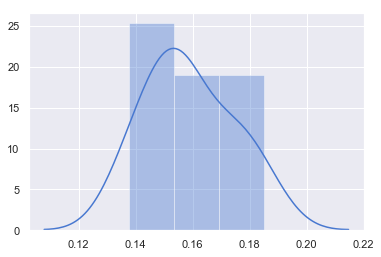

In [38]:
sns.distplot(all_stores_smape)
plt.show()

In [39]:
describe(all_stores_smape)

DescribeResult(nobs=10, minmax=(0.13758328818926086, 0.18497158371207476), mean=0.15876830385920487, variance=0.00023540326049256566, skewness=0.3271973487275687, kurtosis=-0.9587751430852021)

#### Create a model for each item

In [40]:
items_time_series = pd.pivot_table(
    columns=['item','store'], values='sales',
    index=store_item_data.index, data=store_item_data).asfreq('D')
items_time_series.head()

item        1                      ...  50                    
store       1   2   3   4   5   6  ...  5   6   7   8   9   10
date                               ...                        
2013-01-01  13  12  19  10  11  20 ...  19  20  21  45  36  33
2013-01-02  11  16   8  12   9   6 ...  25  23  30  54  44  37
2013-01-03  14  16  10   8  12  11 ...  28  38  20  54  29  46
2013-01-04  13  20  15  15   8   7 ...  27  33  27  52  43  51
2013-01-05  10  16  22  19  13  12 ...  31  33  18  48  53  41

[5 rows x 500 columns]

In [41]:
all_items_smape = evaluate_multiple_var(items_time_series, number_of_items)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 13, BIC -> 6, FPE -> 13, HQIC -> 6>
Using 13 based on aic criterion
0.2043320424047193
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 15, BIC -> 6, FPE -> 15, HQIC -> 6>
Using 15 based on aic criterion
0.1344520268999615
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 13, BIC -> 6, FPE -> 13, HQIC -> 6>
Using 13 based on aic criterion
0.1574192353615655
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 13, BIC -> 6, FPE -> 13, HQIC -> 6>
Using 13 based on aic criterion
0.20120284034167052
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 14, BIC -> 6, FPE -> 14, HQIC -> 6>
Using 14 based on aic criterion
0.24970152598833356
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 13, BIC -> 6, FPE -> 13, HQIC

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 14, BIC -> 6, FPE -> 14, HQIC -> 6>
Using 14 based on aic criterion
0.13822003310461012
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 13, BIC -> 6, FPE -> 13, HQIC -> 6>
Using 13 based on aic criterion
0.1857249079004244
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 13, BIC -> 6, FPE -> 13, HQIC -> 6>
Using 13 based on aic criterion
0.12751262851051903


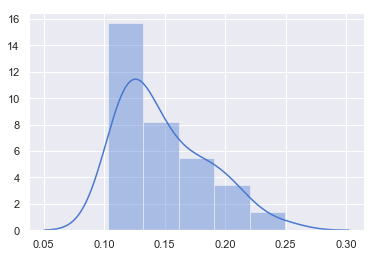

In [43]:
sns.distplot(all_items_smape)

In [44]:
describe(all_items_smape)

DescribeResult(nobs=50, minmax=(0.10294431358820808, 0.24970152598833356), mean=0.14912976749311496, variance=0.0013015468133833435, skewness=0.824155341055402, kurtosis=-0.18818477001434353)